In [12]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
# from keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import math
from sklearn import preprocessing, svm
import datetime as datetime
from matplotlib import style
import time

In [43]:
class year_selector:
    """ Enter the desired year to product a dataframe containing the results from the year.
    Enter the desired number of units for both the first and second layers within the generated n"""
    def __init__(self, chosen_year, first_layer_unit, second_layer_unit):
        self.year = chosen_year
        self.first_layer = first_layer_unit
        self.second_layer = second_layer_unit
        
    def mortality(self):
        primary = pd.read_csv('primary_school.csv')
        secondary_school = pd.read_csv('secondary_school.csv')
        gdp_csv = pd.read_csv('Global_GDP.csv')
        rates = pd.read_csv('mortality_rate.csv')
        
#     PRIMARY SCHOOLING DATA CLEANING
        primary_table = primary.iloc[:,2:]
        cols = list(primary_table.columns)
        cols = [cols[-1]] + cols[:-1]
        primary_table = primary_table[cols]
        primary_table = primary_table.rename(columns={"ISO-alpha3 code":"ISO_Code"})
        primary_table = primary_table[['ISO_Code',self.year]]
        primary_table = primary_table.replace({'..':np.NaN})
        primary_table = primary_table.dropna()
        primary_table = primary_table.rename(columns={primary_table.columns[1]:"Primary_School"})
        
# SECONDARY SCHOOLING DATA CLEANING
        secondary_table = secondary_school.iloc[:,2:]
        cols = list(secondary_table.columns)
        cols = [cols[-1]] + cols[:-1]
        secondary_table = secondary_table[cols]
        secondary_table = secondary_table.rename(columns={"ISO-alpha3 code":"ISO_Code"})
        secondary_table = secondary_table[['ISO_Code',self.year]]
        secondary_table = secondary_table.replace({'..':np.NaN})
        secondary_table = secondary_table.dropna()
        secondary_table = secondary_table.rename(columns={secondary_table.columns[1]:"Secondary_School"})

# GDP DATA CLEANING
        gdp_table = gdp_csv.rename(columns={'Country Code':'ISO_Code'})
        gdp_table = gdp_table[['ISO_Code',self.year]]
        gdp_table = gdp_table.rename(columns={gdp_table.columns[1]:"GDP_per_Capita"})

    
#     MORTALITY RATES DATA CLEANING
        codes = rates['ISO Code']
        counter = 0
        country_id = []
        for code in codes:
            if counter < 1:
                counter += 1
                country_id.append(code)
            elif counter < 2:
                counter += 1
            else:
                counter = 0  
        ids = pd.DataFrame(country_id)
        year = rates[self.year]
        averages = year.groupby(np.arange(len(year))//3).mean()
        year = pd.DataFrame(averages)
        rates_table = pd.concat([ids, year],axis=1)
        rates_table = rates_table.rename(columns={0:'ISO_Code'})
        rates_table = rates_table.rename(columns={rates_table.columns[1]:"Mortality_Rates"})


# MERGE ALL OF THE DATA TOGETHER 
        final_table = pd.merge(primary_table, secondary_table, on='ISO_Code', how='inner')
        final_table = pd.merge(final_table, gdp_table, on='ISO_Code', how='inner')
        final_table = pd.merge(final_table, rates_table, on='ISO_Code', how='inner')
        
#         DATA PRE-PROCESSING
        X = final_table.loc[:, ['Primary_School','Secondary_School','GDP_per_Capita']]
        y = final_table['Mortality_Rates'].values.reshape(-1,1)
#         print(X.shape,y.shape)

        # LOOK UP (, random_state=#)
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
        # insert test_size=... and train_size=... 
        X_scaler = StandardScaler().fit(X_train)
        y_scaler = StandardScaler().fit(y_train)

        # Transform the training and testing data using the X_scaler and y_scaler models
        X_train_scaled = X_scaler.transform(X_train)
        X_test_scaled = X_scaler.transform(X_test)
        y_train_scaled = y_scaler.transform(y_train)
        y_test_scaled = y_scaler.transform(y_test)

        model = Sequential()
        model.add(Dense(units=self.first_layer, activation='relu', input_dim=3, kernel_initializer='random_uniform'))
        model.add(Dense(units=self.second_layer, activation='relu'))
        model.add(Dense(units=1, activation='linear'))
        
        model.compile(optimizer='adam',
             loss = 'mean_squared_error',
             metrics=["acc"])

        model.fit(
            X_train_scaled, 
            y_train_scaled, 
            epochs=60, 
            shuffle=True, 
            verbose=2)
        
        model.summary()
        
        model = LinearRegression()
        
        model.fit(X_train, y_train)
        training_score = model.score(X_train, y_train)
        testing_score = model.score(X_test, y_test)
        print(f"Training Score: {training_score}")
        print(f"Testing Score: {testing_score}")
        
#       RESIDUAL PLOT
        plt.scatter(model.predict(X_train), model.predict(X_train) - y_train, c="blue", label="Training Data")
        plt.scatter(model.predict(X_test), model.predict(X_test) - y_test, c="orange", label="Testing Data")
        plt.legend()
        plt.hlines(y=0, xmin=y.min(), xmax=y.max())
        plt.title("Residual Plot")
        
#       MEAN SQUARED ERROR, R-SQUARED, AND PREDICTIONS
        from sklearn.metrics import mean_squared_error

        predictions = model.predict(X_test_scaled)
        MSE = mean_squared_error(y_test_scaled, predictions)
        r2 = model.score(X_test_scaled, y_test_scaled)

        print(f"MSE: {MSE}, R2: {r2}")
        print(predictions)

        return(final_table)

/Users/davidcdainko/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/davidcdainko/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:81: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
/Users/davidcdainko/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:82: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.


Epoch 1/60
 - 1s - loss: 0.9899 - acc: 0.0000e+00
Epoch 2/60
 - 0s - loss: 0.9746 - acc: 0.0000e+00
Epoch 3/60
 - 0s - loss: 0.9591 - acc: 0.0000e+00
Epoch 4/60
 - 0s - loss: 0.9433 - acc: 0.0000e+00
Epoch 5/60
 - 0s - loss: 0.9279 - acc: 0.0000e+00
Epoch 6/60
 - 0s - loss: 0.9120 - acc: 0.0000e+00
Epoch 7/60
 - 0s - loss: 0.8955 - acc: 0.0000e+00
Epoch 8/60
 - 0s - loss: 0.8791 - acc: 0.0000e+00
Epoch 9/60
 - 0s - loss: 0.8632 - acc: 0.0000e+00
Epoch 10/60
 - 0s - loss: 0.8465 - acc: 0.0000e+00
Epoch 11/60
 - 0s - loss: 0.8305 - acc: 0.0000e+00
Epoch 12/60
 - 0s - loss: 0.8150 - acc: 0.0000e+00
Epoch 13/60
 - 0s - loss: 0.7992 - acc: 0.0000e+00
Epoch 14/60
 - 0s - loss: 0.7840 - acc: 0.0000e+00
Epoch 15/60
 - 0s - loss: 0.7681 - acc: 0.0000e+00
Epoch 16/60
 - 0s - loss: 0.7519 - acc: 0.0000e+00
Epoch 17/60
 - 0s - loss: 0.7348 - acc: 0.0000e+00
Epoch 18/60
 - 0s - loss: 0.7165 - acc: 0.0000e+00
Epoch 19/60
 - 0s - loss: 0.6983 - acc: 0.0000e+00
Epoch 20/60
 - 0s - loss: 0.6785 - acc: 

,ISO_Code,Primary_School,Secondary_School,GDP_per_Capita,Mortality_Rates
0,ARG,1.48949,10.68215,12969.707120,13.333333
1,ARM,3.10982,2.70915,3684.804810,16.500000
2,AZE,11.89319,6.59099,7496.294648,33.133333
3,BEL,1.86731,4.17825,44826.439610,4.300000
4,BLZ,0.19255,2.26201,4644.559565,17.800000
5,BOL,10.43243,20.19972,2645.227753,42.500000
6,BGR,2.16056,4.66862,7378.024730,9.800000
7,BFA,35.60472,12.6314,673.822818,103.566667
8,CPV,13.80365,7.53909,3408.482762,23.333333
9,COL,5.68409,19.5499,7904.495789,17.533333


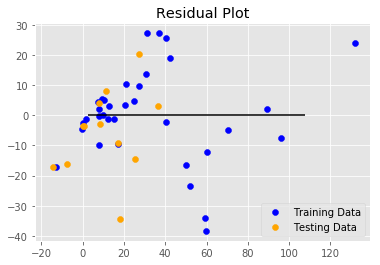

In [44]:
user = year_selector('2012', 30, 20)
results = user.mortality()
results

In [35]:
class country_selector:
    """Insert the desired country to generate a predictive chart depicting the model's predicted mortality 
    for the next couple of years as well as a prediction size e.g.) 0.1 to determine what percentage of the 
    data to use in generating predictions"""
    def __init__(self, chosen_country, prediction_size):
        self.country = chosen_country
        self.predictionsize = prediction_size
        
    def prediction_chart(self):

#         EXTRACT DATA FROM CSV'S
        primary_school = pd.read_csv('primary_school.csv')
        df_gdp = pd.read_csv('Global_GDP.csv')
        mortalities = pd.read_csv('mortality_rate.csv')
        
        try:
        
    #         FILTER FOR THE SELECTED COUNTRY
            selected_primary = primary_school.loc[primary_school['Country']==self.country]
            selected_gdp = df_gdp.loc[df_gdp['Country Name']==self.country]
            selected_mortalities = mortalities.loc[mortalities['Country Name']==self.country]

    #         CLEAN THE DATA:
    # PRIMARY
            selected_primary = selected_primary.iloc[:,2:-1]
            selected_primary = selected_primary.transpose()
            selected_primary = selected_primary.rename(columns={selected_primary.columns[0]:"Primary_School"})

    # SECONDARY

    # GDP
            selected_gdp = selected_gdp.iloc[:,3:]
            selected_gdp = selected_gdp.transpose()
            selected_gdp = selected_gdp.rename(columns={selected_gdp.columns[0]:"GDP_per_Capita"})

    # MORTALITIES
            codes = selected_mortalities['ISO Code']
            counter = 0
            country_id = []
            for code in codes:
                if counter < 1:
                    counter += 1
                    country_id.append(code)
                elif counter < 2:
                    counter += 1
                else:
                    counter = 0
            country_id = pd.DataFrame(country_id)
            avg_mortalities = selected_mortalities.groupby(np.arange(len(selected_mortalities))//3).mean()
            selected_mortalities = pd.concat([country_id, avg_mortalities],axis=1)
            selected_mortalities = selected_mortalities.iloc[:,1:]
            selected_mortalities = selected_mortalities.transpose()
            selected_mortalities = selected_mortalities.rename(columns={selected_mortalities.columns[0]:"Mortality_Rate"})

    #         JOIN THE TABLES
            joined_table = selected_primary.join(selected_gdp, how='inner')
            joined_table = joined_table.join(selected_mortalities, how='inner')
            joined_table = joined_table.replace({'..':np.NaN})
            joined_table = joined_table.dropna()

    #         CREATE PREDICTIVE CHART
            forecast_out = int(math.ceil(self.predictionsize*len(joined_table)))
            forecast_col = 'Mortality_Rate'
            joined_table['label'] = joined_table[forecast_col].shift(-forecast_out)

            X = np.array(joined_table.drop(['label'],1))
            X = preprocessing.scale(X)
            X = X[:-forecast_out]
            X_lately = X[-forecast_out:]
            joined_table.dropna(inplace=True)
            y = np.array(joined_table['label'])
            y = np.array(joined_table['label'])


            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
            clf = LinearRegression(n_jobs=-1)
            clf.fit(X_train, y_train)
            accuracy = clf.score(X_test, y_test)

            forecast_set = clf.predict(X_lately)

            style.use('ggplot')

            joined_table["Forecast"] = np.NaN

            last_date = joined_table.iloc[-1].name
            last_unix = time.mktime(datetime.datetime.strptime(last_date, '%Y').timetuple())
            one_year = 31536000
            next_unix = last_unix + one_year

            for i in forecast_set:
                next_year = datetime.datetime.fromtimestamp(next_unix)
                next_unix += one_year
                next_year = next_year.year
                joined_table.loc[next_year] = [np.NaN for _ in range(len(joined_table.columns)-1)] + [i]

            joined_table['Mortality_Rate'].plot()
            joined_table['Forecast'].plot()
            plt.legend(loc=3)
            plt.xlabel('Year')
            plt.ylabel('Mortality Rate')
            plt.show()

            return(joined_table, forecast_set, accuracy, forecast_out)
        
        except ValueError:
            return('Try a different country')


/Users/davidcdainko/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


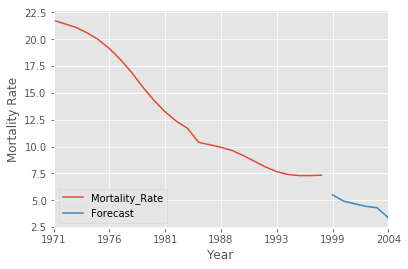

(     Primary_School  GDP_per_Capita  Mortality_Rate      label  Forecast
 1971        4.59363     1705.972661       21.766667  16.900000       NaN
 1972        6.02848     2082.956898       21.433333  15.533333       NaN
 1973        5.79329     2427.172361       21.100000  14.300000       NaN
 1974        6.44096     2519.941754       20.600000  13.233333       NaN
 1975        5.61503     2976.961022       19.966667  12.366667       NaN
 1976        4.61964     2923.079756       19.133333  11.700000       NaN
 1977        3.90134     3431.177594       18.100000  10.400000       NaN
 1978        3.47226     4405.256228       16.900000  10.166667       NaN
 1979        4.42332     5436.465018       15.533333   9.933333       NaN
 1980         6.2486     6380.069668       14.300000   9.633333       NaN
 1981        8.87999     5993.323120       13.233333   9.166667       NaN
 1982       11.63434     6168.016540       12.366667   8.633333       NaN
 1983       13.48394     5922.326009  

In [38]:
user = country_selector('Ireland', 0.2)
results = user.prediction_chart()
results